In [1]:
# Import modules
import datetime

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import spiceypy

# Load the SPICE kernels
spiceypy.furnsh("../kernels/lsk/naif0012.tls")
spiceypy.furnsh("../kernels/spk/de432s.bsp")
spiceypy.furnsh("../kernels/pck/pck00010.tpc")

# start from jan 1st of 2000
init_time_utc = datetime.datetime(year=2000, month=1, day=1, hour=0, minute=0, second=0)

# change over a period of 10.000 days
delta_days = 10000
end_time_utc = init_time_utc + datetime.timedelta(days=delta_days)

# Convert the datetime objects now to strings
init_time_utc_str = init_time_utc.strftime('%Y-%m-%dT%H:%H:%S')
end_time_utc_str = end_time_utc.strftime('%Y-%m-%dT%H:%H:%S')

# Convert to ET
init_time_et = spiceypy.utc2et(init_time_utc_str)
end_time_et = spiceypy.utc2et(end_time_utc_str)

# Create a numpy array that covers a time interval in delta = 1 day step
time_interval_et = np.linspace(init_time_et, end_time_et, delta_days)

/tmp/ipykernel_719/2364751082.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# get the radius of the sun
_, radii = spiceypy.bodvcd(bodyid=10, item="RADII", maxn=3)

radius_sun = radii[0]

In [3]:
#create a dataframe
solar_system_dataframe = pd.DataFrame()

# add the time intervals in ET and a readable time
solar_system_dataframe.loc[:,"ET"]  = time_interval_et
solar_system_dataframe.loc[:,"UTC"] = solar_system_dataframe["ET"].apply(lambda x: spiceypy.et2datetime(et=x).date())

# add the data from the sun to the ssb to its own column
solar_system_dataframe.loc[:,"POSITION_SSB_TO_SUN"] = solar_system_dataframe["ET"].apply(lambda x: spiceypy.spkgps(targ=0, et=x, ref="ECLIPJ2000", obs=10)[0])

#normalize the info from POSITION_SSB_TO_SUN
solar_system_dataframe.loc[:,"POSITION_SSB_TO_SUN_NORM"] = solar_system_dataframe["POSITION_SSB_TO_SUN"].apply(lambda x: x /radius_sun)

# distance each day in sun radii
solar_system_dataframe.loc[:,"SSB_TO_SUN_NORM_DISTANCE"] = solar_system_dataframe["POSITION_SSB_TO_SUN_NORM"].apply(lambda x: spiceypy.vnorm(x))

In [4]:
# compute angle for planets dictionary
NAIF_id_DICT = {"Mercury": 1, "Venus": 2, "Earth": 3, "Mars": 4, "Jupiter": 5, "Saturn": 6, "Uranus": 7, "Neptune": 8, "Pluto": 9}

# iterate over the dict 
for planet in NAIF_id_DICT:
    # add column names
    planet_pos_col = f"position_{planet}_from_sun"
    planet_angle_col = f"PHASE_ANGLE_SUN_{planet}2SSB"

    #get planet id from each planet
    planet_id = NAIF_id_DICT[planet]

    # compute the positions of the planets from the sun
    solar_system_dataframe.loc[:,planet_pos_col] = solar_system_dataframe["ET"].apply(lambda x: spiceypy.spkgps(targ=planet_id, et=x, ref="ECLIPJ2000", obs=10)[0])

    # compute angles between planet and position of the SSB
    solar_system_dataframe.loc[:,planet_angle_col] = solar_system_dataframe.apply(lambda x: np.degrees(spiceypy.vsep(x[planet_pos_col], x["POSITION_SSB_TO_SUN"])), axis=1)


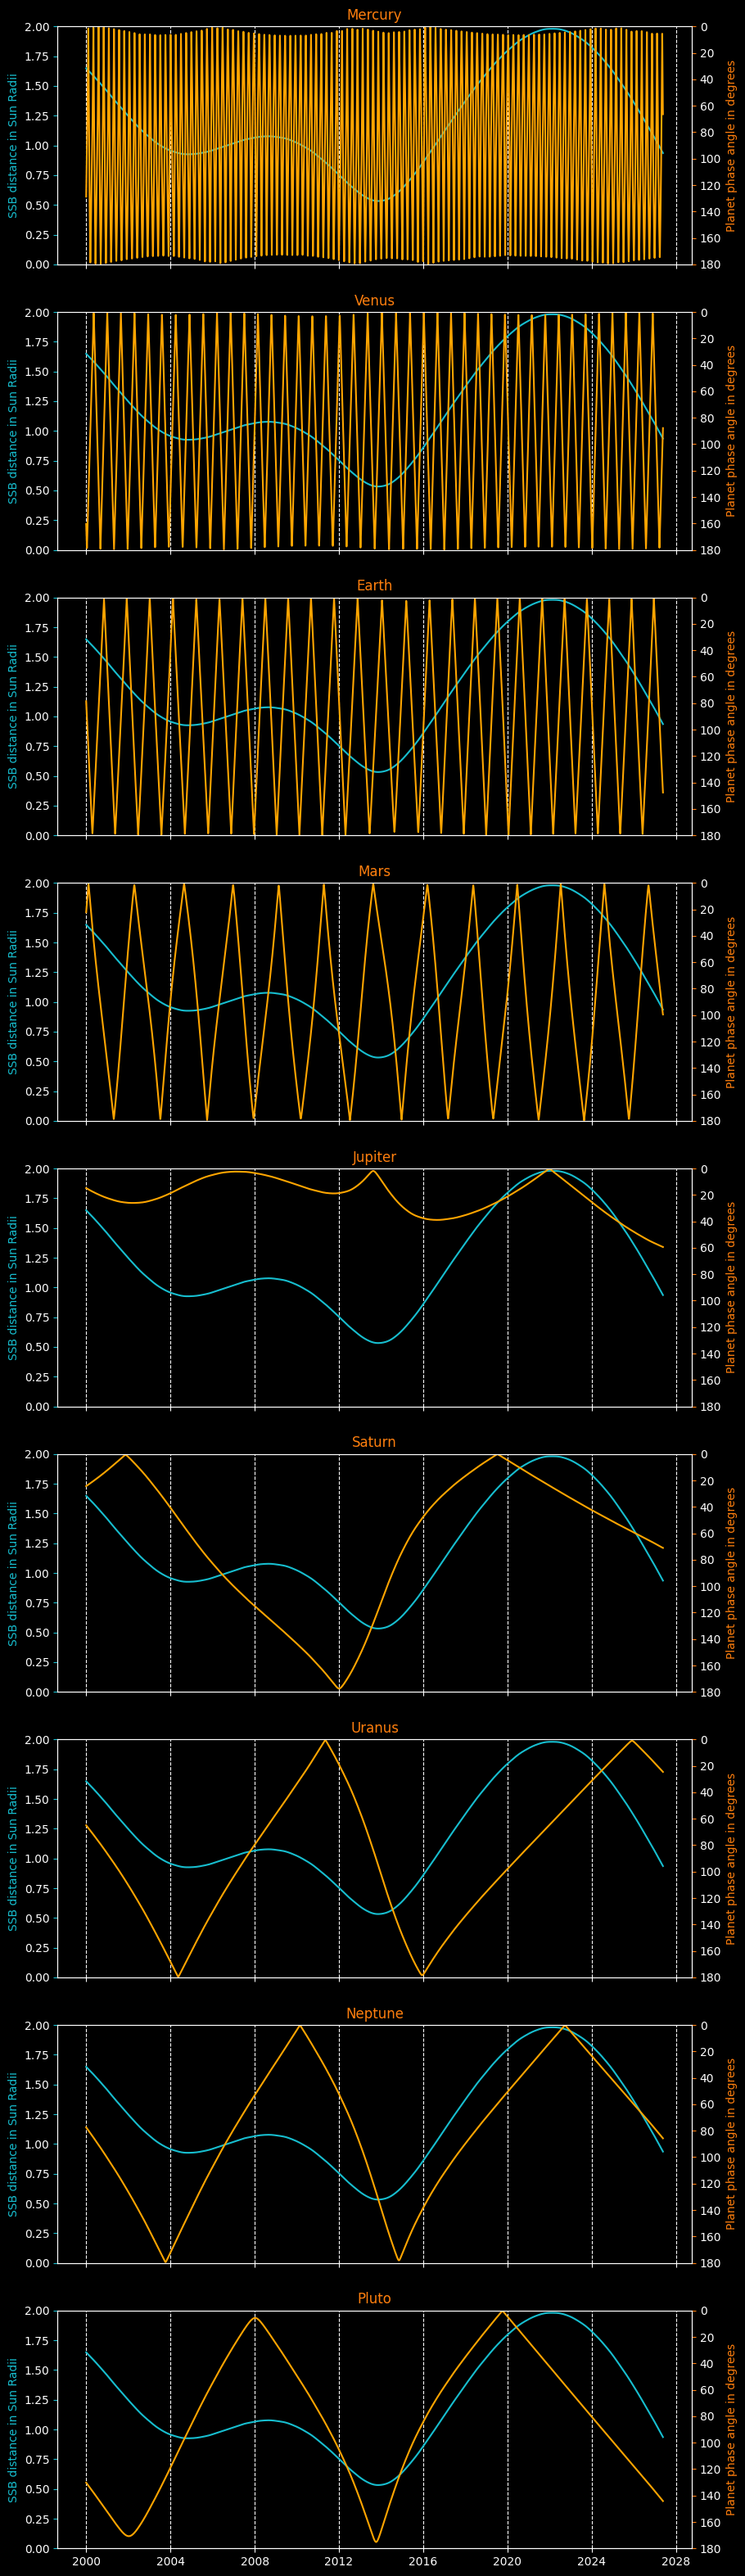

In [5]:
# create a graph to compare angles of the planets to see if the combined forces draw the SSB closer together
plt.style.use("dark_background")
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9) = plt.subplots(9, 1, sharex=True, figsize=(10,40))

for ax_f, planet_name in zip([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9], ["Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "Pluto"]):
    ax_f.set_title(planet_name, color="tab:orange")
    # create the first plot showing the movement of the ssb
    ax_f.plot(solar_system_dataframe["UTC"], solar_system_dataframe["SSB_TO_SUN_NORM_DISTANCE"], color="tab:cyan")

    # some prettifying of the plot
    ax_f.set_ylabel("SSB distance in Sun Radii", color="tab:cyan")
    ax_f.tick_params(axis="y", color="tab:cyan")
    ax_f.set_ylim(0, 2)

    # add the second plot to show the position of the planet
    ax_f_add = ax_f.twinx()
    ax_f_add.plot(solar_system_dataframe["UTC"], solar_system_dataframe[f"PHASE_ANGLE_SUN_{planet_name}2SSB"], color="orange")

    # some prettifying of the plot
    ax_f_add.set_ylabel("Planet phase angle in degrees", color="tab:orange")
    ax_f_add.tick_params(axis="y", color="tab:orange")

    ax_f_add.invert_yaxis()
    ax_f_add.set_ylim(180, 0)

    ax_f.grid(axis="x", linestyle="dashed")

